# Lab-1.4: Ê¢ØÂ∫¶Á¥ØÁ©ç (Gradient Accumulation)

**Â≠∏ÁøíÁõÆÊ®ô**:
- ÁêÜËß£Ê¢ØÂ∫¶Á¥ØÁ©çÂ¶Ç‰ΩïÂØ¶ÁèæÂ§ßÊâπÊ¨°Ë®ìÁ∑¥
- ÊéåÊè°ÊúâÊïàÊâπÊ¨°Â§ßÂ∞èÁöÑË®àÁÆóÊñπÊ≥ï
- Â∞çÊØî‰∏çÂêåÁ¥ØÁ©çÁ≠ñÁï•ÁöÑÊïàÊûú
- Â≠∏ÁøíÁµêÂêàÊ∑∑ÂêàÁ≤æÂ∫¶ÁöÑÂÑ™ÂåñÊäÄÂ∑ß

**È†êË®àÊôÇÈñì**: 45-60ÂàÜÈêò

## 1. ÁêÜË´ñËÉåÊôØ

### 1.1 ‰ªÄÈ∫ºÊòØÊ¢ØÂ∫¶Á¥ØÁ©çÔºü

**ÂïèÈ°å**: GPU Ë®òÊÜ∂È´î‰∏çË∂≥‰ª•ÊîØÊåÅÂ§ßÊâπÊ¨°Ë®ìÁ∑¥

**Ëß£Ê±∫ÊñπÊ°à**: Â∞áÂ§ßÊâπÊ¨°ÂàÜÂâ≤ÊàêÂ§öÂÄãÂ∞èÊâπÊ¨° (micro-batch)ÔºåÁ¥ØÁ©çÊ¢ØÂ∫¶ÂæåÂÜçÊõ¥Êñ∞

### 1.2 Â∑•‰ΩúÂéüÁêÜ

```
ÂÇ≥Áµ±Ë®ìÁ∑¥ (batch_size=32):
  ÂâçÂêëÂÇ≥Êí≠(32) ‚Üí ÂèçÂêëÂÇ≥Êí≠(32) ‚Üí Êõ¥Êñ∞ÂèÉÊï∏ ‚Üí Ê∏ÖÈõ∂Ê¢ØÂ∫¶

Ê¢ØÂ∫¶Á¥ØÁ©ç (micro_batch=8, accumulation=4):
  ÂâçÂêëÂÇ≥Êí≠(8) ‚Üí ÂèçÂêëÂÇ≥Êí≠(8) ‚Üí Á¥ØÁ©çÊ¢ØÂ∫¶
  ÂâçÂêëÂÇ≥Êí≠(8) ‚Üí ÂèçÂêëÂÇ≥Êí≠(8) ‚Üí Á¥ØÁ©çÊ¢ØÂ∫¶  
  ÂâçÂêëÂÇ≥Êí≠(8) ‚Üí ÂèçÂêëÂÇ≥Êí≠(8) ‚Üí Á¥ØÁ©çÊ¢ØÂ∫¶
  ÂâçÂêëÂÇ≥Êí≠(8) ‚Üí ÂèçÂêëÂÇ≥Êí≠(8) ‚Üí Á¥ØÁ©çÊ¢ØÂ∫¶
  ‚Üí Êõ¥Êñ∞ÂèÉÊï∏ ‚Üí Ê∏ÖÈõ∂Ê¢ØÂ∫¶
  
ÊúâÊïàÊâπÊ¨°Â§ßÂ∞è = 8 √ó 4 = 32 (ËàáÂÇ≥Áµ±Ë®ìÁ∑¥Á≠âÊïà)
```

### 1.3 ÈóúÈçµÂÖ¨Âºè

$$\text{Effective Batch Size} = \text{Micro Batch Size} \times \text{Accumulation Steps}$$

$$\text{Ê¢ØÂ∫¶Á¥ØÁ©ç} = \frac{1}{N} \sum_{i=1}^{N} \nabla L_i$$

ÂÖ∂‰∏≠ $N$ ÁÇ∫Á¥ØÁ©çÊ≠•Êï∏

## 2. Áí∞Â¢ÉË®≠ÁΩÆ

In [5]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import gc

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"‰ΩøÁî®Ë®≠ÂÇô: {device}")

PyTorch Version: 2.6.0+cu124
CUDA Available: True
‰ΩøÁî®Ë®≠ÂÇô: cuda


## 3. Êï∏ÊìöÊ∫ñÂÇô

In [6]:
class SimpleTextDataset(Dataset):
    """Á∞°ÂñÆÁöÑÊñáÊú¨Êï∏ÊìöÈõÜ"""
    def __init__(self, tokenizer, num_samples=1000, seq_length=128):
        self.tokenizer = tokenizer
        self.num_samples = num_samples
        self.seq_length = seq_length
        
        # ÁîüÊàêË®ìÁ∑¥ÊñáÊú¨
        self.texts = [
            f"The quick brown fox jumps over the lazy dog. " * 10
            for _ in range(num_samples)
        ]
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encodings = self.tokenizer(
            text,
            max_length=self.seq_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        
        return {
            "input_ids": encodings["input_ids"].squeeze(),
            "attention_mask": encodings["attention_mask"].squeeze(),
            "labels": encodings["input_ids"].squeeze()
        }

# ËºâÂÖ• tokenizer
print("ËºâÂÖ• GPT-2 Tokenizer...")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# ÂâµÂª∫Êï∏ÊìöÈõÜ
dataset = SimpleTextDataset(tokenizer, num_samples=800, seq_length=128)
print(f"Êï∏ÊìöÈõÜÂ§ßÂ∞è: {len(dataset)}")

ËºâÂÖ• GPT-2 Tokenizer...
Êï∏ÊìöÈõÜÂ§ßÂ∞è: 800


## 4. Ë®òÊÜ∂È´îËøΩËπ§Â∑•ÂÖ∑

In [7]:
class MemoryTracker:
    """Ë®òÊÜ∂È´îËøΩËπ§Âô®"""
    def __init__(self):
        self.reset()
    
    def reset(self):
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.empty_cache()
            gc.collect()
    
    def get_memory_mb(self):
        if not torch.cuda.is_available():
            return {"allocated": 0, "peak": 0}
        return {
            "allocated": torch.cuda.memory_allocated() / 1e6,
            "peak": torch.cuda.max_memory_allocated() / 1e6
        }
    
    def print_memory(self, prefix=""):
        stats = self.get_memory_mb()
        print(f"{prefix}Ë®òÊÜ∂È´î - Áï∂Ââç: {stats['allocated']:.0f}MB, Â≥∞ÂÄº: {stats['peak']:.0f}MB")
        return stats

memory_tracker = MemoryTracker()
memory_tracker.reset()

## 5. Ê¢ØÂ∫¶Á¥ØÁ©çË®ìÁ∑¥ÂáΩÊï∏

In [8]:
def train_with_accumulation(
    model,
    dataset,
    micro_batch_size,
    accumulation_steps,
    num_steps=100,
    learning_rate=5e-5,
    use_amp=True,
):
    """
    ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁ©çË®ìÁ∑¥Ê®°Âûã
    
    Args:
        model: ÂæÖË®ìÁ∑¥Ê®°Âûã
        dataset: Ë®ìÁ∑¥Êï∏ÊìöÈõÜ
        micro_batch_size: ÊØèÊ¨°ÂâçÂêëÂÇ≥Êí≠ÁöÑÊâπÊ¨°Â§ßÂ∞è
        accumulation_steps: Ê¢ØÂ∫¶Á¥ØÁ©çÊ≠•Êï∏
        num_steps: Á∏ΩË®ìÁ∑¥Ê≠•Êï∏
        learning_rate: Â≠∏ÁøíÁéá
        use_amp: ÊòØÂê¶‰ΩøÁî®Ê∑∑ÂêàÁ≤æÂ∫¶
    """
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scaler = GradScaler() if use_amp else None
    
    # ÂâµÂª∫ DataLoader
    dataloader = DataLoader(dataset, batch_size=micro_batch_size, shuffle=True)
    dataloader_iter = iter(dataloader)
    
    # ÈáçÁΩÆË®òÊÜ∂È´îËøΩËπ§
    memory_tracker.reset()
    
    # Ë®ìÁ∑¥Áµ±Ë®à
    losses = []
    start_time = time.time()
    
    # ÊúâÊïàÊâπÊ¨°Â§ßÂ∞è
    effective_batch_size = micro_batch_size * accumulation_steps
    
    pbar = tqdm(range(num_steps), desc=f"Training (bs={effective_batch_size})")
    model.zero_grad()
    
    for step in pbar:
        step_loss = 0.0
        
        # Ê¢ØÂ∫¶Á¥ØÁ©çÂæ™Áí∞
        for accum_step in range(accumulation_steps):
            try:
                batch = next(dataloader_iter)
            except StopIteration:
                dataloader_iter = iter(dataloader)
                batch = next(dataloader_iter)
            
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # ÂâçÂêëÂÇ≥Êí≠
            if use_amp:
                with autocast(dtype=torch.float16):
                    outputs = model(**batch)
                    loss = outputs.loss / accumulation_steps  # Âπ≥ÂùáÊêçÂ§±
                
                # ÂèçÂêëÂÇ≥Êí≠ (Á¥ØÁ©çÊ¢ØÂ∫¶)
                scaler.scale(loss).backward()
            else:
                outputs = model(**batch)
                loss = outputs.loss / accumulation_steps
                loss.backward()
            
            step_loss += loss.item()
        
        # Á¥ØÁ©çÂÆåÊàê, Êõ¥Êñ∞ÂèÉÊï∏
        if use_amp:
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.step()
        
        optimizer.zero_grad()
        
        losses.append(step_loss)
        pbar.set_postfix({"loss": f"{step_loss:.4f}"})
    
    # Áµ±Ë®àÁµêÊûú
    training_time = time.time() - start_time
    memory_stats = memory_tracker.get_memory_mb()
    
    return {
        "losses": losses,
        "avg_loss": np.mean(losses),
        "final_loss": losses[-1],
        "training_time": training_time,
        "steps_per_sec": num_steps / training_time,
        "peak_memory_mb": memory_stats["peak"],
        "effective_batch_size": effective_batch_size
    }

## 6. ÂØ¶È©ó 1: Â∞èÊâπÊ¨°Âü∫Ê∫ñ (ÁÑ°Ê¢ØÂ∫¶Á¥ØÁ©ç)

In [9]:
print("=" * 70)
print("ÂØ¶È©ó 1: Â∞èÊâπÊ¨°Ë®ìÁ∑¥ (ÁÑ°Ê¢ØÂ∫¶Á¥ØÁ©ç)")
print("=" * 70)

# ËºâÂÖ•Ê®°Âûã
model_baseline = GPT2LMHeadModel.from_pretrained("gpt2")
model_baseline = model_baseline.to(device)

print(f"\nÈÖçÁΩÆ: micro_batch_size=2, accumulation_steps=1")
print(f"ÊúâÊïàÊâπÊ¨°Â§ßÂ∞è: 2 √ó 1 = 2")

# Ë®ìÁ∑¥
results_baseline = train_with_accumulation(
    model=model_baseline,
    dataset=dataset,
    micro_batch_size=2,
    accumulation_steps=1,  # ÁÑ°Á¥ØÁ©ç
    num_steps=100,
    use_amp=True,
)

# È°ØÁ§∫ÁµêÊûú
print("\n" + "=" * 70)
print("Âü∫Ê∫ñÁµêÊûú (batch_size=2)")
print("=" * 70)
print(f"Âπ≥Âùá Loss: {results_baseline['avg_loss']:.4f}")
print(f"ÊúÄÁµÇ Loss: {results_baseline['final_loss']:.4f}")
print(f"Ë®ìÁ∑¥ÊôÇÈñì: {results_baseline['training_time']:.2f} Áßí")
print(f"Â≥∞ÂÄºË®òÊÜ∂È´î: {results_baseline['peak_memory_mb']:.0f} MB")

# Ê∏ÖÁêÜ
del model_baseline
memory_tracker.reset()

ÂØ¶È©ó 1: Â∞èÊâπÊ¨°Ë®ìÁ∑¥ (ÁÑ°Ê¢ØÂ∫¶Á¥ØÁ©ç)

ÈÖçÁΩÆ: micro_batch_size=2, accumulation_steps=1
ÊúâÊïàÊâπÊ¨°Â§ßÂ∞è: 2 √ó 1 = 2


/tmp/ipykernel_3826037/1026604448.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None


Training (bs=2):   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_3826037/1026604448.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.



Âü∫Ê∫ñÁµêÊûú (batch_size=2)
Âπ≥Âùá Loss: 0.2121
ÊúÄÁµÇ Loss: 0.0126
Ë®ìÁ∑¥ÊôÇÈñì: 8.95 Áßí
Â≥∞ÂÄºË®òÊÜ∂È´î: 3064 MB


## 7. ÂØ¶È©ó 2: Ê¢ØÂ∫¶Á¥ØÁ©ç (accumulation_steps=4)

In [10]:
print("=" * 70)
print("ÂØ¶È©ó 2: Ê¢ØÂ∫¶Á¥ØÁ©ç (accumulation_steps=4)")
print("=" * 70)

# ËºâÂÖ•Ê®°Âûã
model_acc4 = GPT2LMHeadModel.from_pretrained("gpt2")
model_acc4 = model_acc4.to(device)

print(f"\nÈÖçÁΩÆ: micro_batch_size=2, accumulation_steps=4")
print(f"ÊúâÊïàÊâπÊ¨°Â§ßÂ∞è: 2 √ó 4 = 8")

# Ë®ìÁ∑¥
results_acc4 = train_with_accumulation(
    model=model_acc4,
    dataset=dataset,
    micro_batch_size=2,
    accumulation_steps=4,
    num_steps=100,
    use_amp=True
)

# È°ØÁ§∫ÁµêÊûú
print("\n" + "=" * 70)
print("Ê¢ØÂ∫¶Á¥ØÁ©çÁµêÊûú (effective_batch_size=8)")
print("=" * 70)
print(f"Âπ≥Âùá Loss: {results_acc4['avg_loss']:.4f}")
print(f"ÊúÄÁµÇ Loss: {results_acc4['final_loss']:.4f}")
print(f"Ë®ìÁ∑¥ÊôÇÈñì: {results_acc4['training_time']:.2f} Áßí")
print(f"Â≥∞ÂÄºË®òÊÜ∂È´î: {results_acc4['peak_memory_mb']:.0f} MB")

# Ê∏ÖÁêÜ
del model_acc4
memory_tracker.reset()

ÂØ¶È©ó 2: Ê¢ØÂ∫¶Á¥ØÁ©ç (accumulation_steps=4)

ÈÖçÁΩÆ: micro_batch_size=2, accumulation_steps=4
ÊúâÊïàÊâπÊ¨°Â§ßÂ∞è: 2 √ó 4 = 8


/tmp/ipykernel_3826037/1026604448.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None


Training (bs=8):   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_3826037/1026604448.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):



Ê¢ØÂ∫¶Á¥ØÁ©çÁµêÊûú (effective_batch_size=8)
Âπ≥Âùá Loss: 0.1714
ÊúÄÁµÇ Loss: 0.0196
Ë®ìÁ∑¥ÊôÇÈñì: 20.98 Áßí
Â≥∞ÂÄºË®òÊÜ∂È´î: 3173 MB


## 8. ÂØ¶È©ó 3: Êõ¥Â§ßÁöÑÊ¢ØÂ∫¶Á¥ØÁ©ç (accumulation_steps=8)

In [11]:
print("=" * 70)
print("ÂØ¶È©ó 3: Ê¢ØÂ∫¶Á¥ØÁ©ç (accumulation_steps=8)")
print("=" * 70)

# ËºâÂÖ•Ê®°Âûã
model_acc8 = GPT2LMHeadModel.from_pretrained("gpt2")
model_acc8 = model_acc8.to(device)

print(f"\nÈÖçÁΩÆ: micro_batch_size=2, accumulation_steps=8")
print(f"ÊúâÊïàÊâπÊ¨°Â§ßÂ∞è: 2 √ó 8 = 16")

# Ë®ìÁ∑¥
results_acc8 = train_with_accumulation(
    model=model_acc8,
    dataset=dataset,
    micro_batch_size=2,
    accumulation_steps=8,
    num_steps=100,
    use_amp=True
)

# È°ØÁ§∫ÁµêÊûú
print("\n" + "=" * 70)
print("Ê¢ØÂ∫¶Á¥ØÁ©çÁµêÊûú (effective_batch_size=16)")
print("=" * 70)
print(f"Âπ≥Âùá Loss: {results_acc8['avg_loss']:.4f}")
print(f"ÊúÄÁµÇ Loss: {results_acc8['final_loss']:.4f}")
print(f"Ë®ìÁ∑¥ÊôÇÈñì: {results_acc8['training_time']:.2f} Áßí")
print(f"Â≥∞ÂÄºË®òÊÜ∂È´î: {results_acc8['peak_memory_mb']:.0f} MB")

# Ê∏ÖÁêÜ
del model_acc8
memory_tracker.reset()



ÂØ¶È©ó 3: Ê¢ØÂ∫¶Á¥ØÁ©ç (accumulation_steps=8)

ÈÖçÁΩÆ: micro_batch_size=2, accumulation_steps=8
ÊúâÊïàÊâπÊ¨°Â§ßÂ∞è: 2 √ó 8 = 16


/tmp/ipykernel_3826037/1026604448.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None


Training (bs=16):   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_3826037/1026604448.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):



Ê¢ØÂ∫¶Á¥ØÁ©çÁµêÊûú (effective_batch_size=16)
Âπ≥Âùá Loss: 0.1443
ÊúÄÁµÇ Loss: 0.0077
Ë®ìÁ∑¥ÊôÇÈñì: 38.16 Áßí
Â≥∞ÂÄºË®òÊÜ∂È´î: 2663 MB


## 9. ÂØ¶È©ó 4: Ê•µÂ§ßÊâπÊ¨°Ê¢ØÂ∫¶Á¥ØÁ©ç (accumulation_steps=16)

In [12]:
print("=" * 70)
print("ÂØ¶È©ó 4: Ê¢ØÂ∫¶Á¥ØÁ©ç (accumulation_steps=16)")
print("=" * 70)

# ËºâÂÖ•Ê®°Âûã
model_acc16 = GPT2LMHeadModel.from_pretrained("gpt2")
model_acc16 = model_acc16.to(device)

print(f"\nÈÖçÁΩÆ: micro_batch_size=2, accumulation_steps=16")
print(f"ÊúâÊïàÊâπÊ¨°Â§ßÂ∞è: 2 √ó 16 = 32")

# Ë®ìÁ∑¥
results_acc16 = train_with_accumulation(
    model=model_acc16,
    dataset=dataset,
    micro_batch_size=2,
    accumulation_steps=16,
    num_steps=100,
    use_amp=True
)

# È°ØÁ§∫ÁµêÊûú
print("\n" + "=" * 70)
print("Ê¢ØÂ∫¶Á¥ØÁ©çÁµêÊûú (effective_batch_size=32)")
print("=" * 70)
print(f"Âπ≥Âùá Loss: {results_acc16['avg_loss']:.4f}")
print(f"ÊúÄÁµÇ Loss: {results_acc16['final_loss']:.4f}")
print(f"Ë®ìÁ∑¥ÊôÇÈñì: {results_acc16['training_time']:.2f} Áßí")
print(f"Â≥∞ÂÄºË®òÊÜ∂È´î: {results_acc16['peak_memory_mb']:.0f} MB")

# Ê∏ÖÁêÜ
del model_acc16
memory_tracker.reset()

ÂØ¶È©ó 4: Ê¢ØÂ∫¶Á¥ØÁ©ç (accumulation_steps=16)

ÈÖçÁΩÆ: micro_batch_size=2, accumulation_steps=16
ÊúâÊïàÊâπÊ¨°Â§ßÂ∞è: 2 √ó 16 = 32


/tmp/ipykernel_3826037/1026604448.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None


Training (bs=32):   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_3826037/1026604448.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):



Ê¢ØÂ∫¶Á¥ØÁ©çÁµêÊûú (effective_batch_size=32)
Âπ≥Âùá Loss: 0.1188
ÊúÄÁµÇ Loss: 0.0172
Ë®ìÁ∑¥ÊôÇÈñì: 70.35 Áßí
Â≥∞ÂÄºË®òÊÜ∂È´î: 2663 MB


## 10. ÊÄßËÉΩÂ∞çÊØîÂàÜÊûê

In [17]:
# Êï¥ÁêÜÁµêÊûú
all_results = [
    ("Baseline (BS=2)", results_baseline),
    ("Accum√ó4 (BS=8)", results_acc4),
    ("Accum√ó8 (BS=16)", results_acc8),
    ("Accum√ó16 (BS=32)", results_acc16)
]

print("\n" + "=" * 90)
print("Ê¢ØÂ∫¶Á¥ØÁ©çÊÄßËÉΩÂ∞çÊØî")
print("=" * 90)
print(f"{'ÈÖçÁΩÆ':<20} {'ÊúâÊïàBS':<10} {'Âπ≥ÂùáLoss':<12} {'ÊúÄÁµÇLoss':<12} {'ÊôÇÈñì(s)':<10} {'Ë®òÊÜ∂È´î(MB)':<12}")
print("-" * 90)

for name, result in all_results:
    print(f"{name:<20} "
          f"{result['effective_batch_size']:<10} "
          f"{result['avg_loss']:<12.4f} "
          f"{result['final_loss']:<12.4f} "
          f"{result['training_time']:<10.2f} "
          f"{result['peak_memory_mb']:<12.0f}")

# ÂàÜÊûêË®òÊÜ∂È´î‰ΩøÁî®
print("\n" + "=" * 90)
print("ÈóúÈçµÁôºÁèæ")
print("=" * 90)
print(f"1. Ë®òÊÜ∂È´î‰ΩøÁî®: ÊâÄÊúâÈÖçÁΩÆË®òÊÜ∂È´îÂç†Áî®Áõ∏Ëøë (~{results_baseline['peak_memory_mb']:.0f}MB)")
print(f"   ‚Üí Ê¢ØÂ∫¶Á¥ØÁ©ç‰∏çÊúÉÂ¢ûÂä†Ë®òÊÜ∂È´îÂ≥∞ÂÄº ‚úÖ")
print(f"\n2. Ë®ìÁ∑¥ÊôÇÈñì: Á¥ØÁ©çÊ≠•Êï∏Ë∂äÂ§ß, ÊôÇÈñìÁï•ÂæÆÂ¢ûÂä†")
print(f"   ‚Üí Baseline: {results_baseline['training_time']:.1f}s")
print(f"   ‚Üí Accum√ó16: {results_acc16['training_time']:.1f}s (+{(results_acc16['training_time']/results_baseline['training_time']-1)*100:.1f}%)")
print(f"\n3. Ë®ìÁ∑¥ÊïàÊûú: Êõ¥Â§ßÁöÑÊâπÊ¨°ÈÄöÂ∏∏Â∏∂‰æÜÊõ¥Á©©ÂÆöÁöÑË®ìÁ∑¥")
print(f"   ‚Üí ËßÄÂØü Loss Êõ≤Á∑öÁöÑÂπ≥ÊªëÂ∫¶Â∑ÆÁï∞")


Ê¢ØÂ∫¶Á¥ØÁ©çÊÄßËÉΩÂ∞çÊØî
ÈÖçÁΩÆ                   ÊúâÊïàBS       Âπ≥ÂùáLoss       ÊúÄÁµÇLoss       ÊôÇÈñì(s)      Ë®òÊÜ∂È´î(MB)     
------------------------------------------------------------------------------------------
Baseline (BS=2)      2          0.2121       0.0126       8.95       3064        
Accum√ó4 (BS=8)       8          0.1714       0.0196       20.98      3173        
Accum√ó8 (BS=16)      16         0.1443       0.0077       38.16      2663        
Accum√ó16 (BS=32)     32         0.1188       0.0172       70.35      2663        

ÈóúÈçµÁôºÁèæ
1. Ë®òÊÜ∂È´î‰ΩøÁî®: ÊâÄÊúâÈÖçÁΩÆË®òÊÜ∂È´îÂç†Áî®Áõ∏Ëøë (~3064MB)
   ‚Üí Ê¢ØÂ∫¶Á¥ØÁ©ç‰∏çÊúÉÂ¢ûÂä†Ë®òÊÜ∂È´îÂ≥∞ÂÄº ‚úÖ

2. Ë®ìÁ∑¥ÊôÇÈñì: Á¥ØÁ©çÊ≠•Êï∏Ë∂äÂ§ß, ÊôÇÈñìÁï•ÂæÆÂ¢ûÂä†
   ‚Üí Baseline: 9.0s
   ‚Üí Accum√ó16: 70.3s (+685.8%)

3. Ë®ìÁ∑¥ÊïàÊûú: Êõ¥Â§ßÁöÑÊâπÊ¨°ÈÄöÂ∏∏Â∏∂‰æÜÊõ¥Á©©ÂÆöÁöÑË®ìÁ∑¥
   ‚Üí ËßÄÂØü Loss Êõ≤Á∑öÁöÑÂπ≥ÊªëÂ∫¶Â∑ÆÁï∞


## 11. Ë¶ñË¶∫ÂåñÂ∞çÊØî

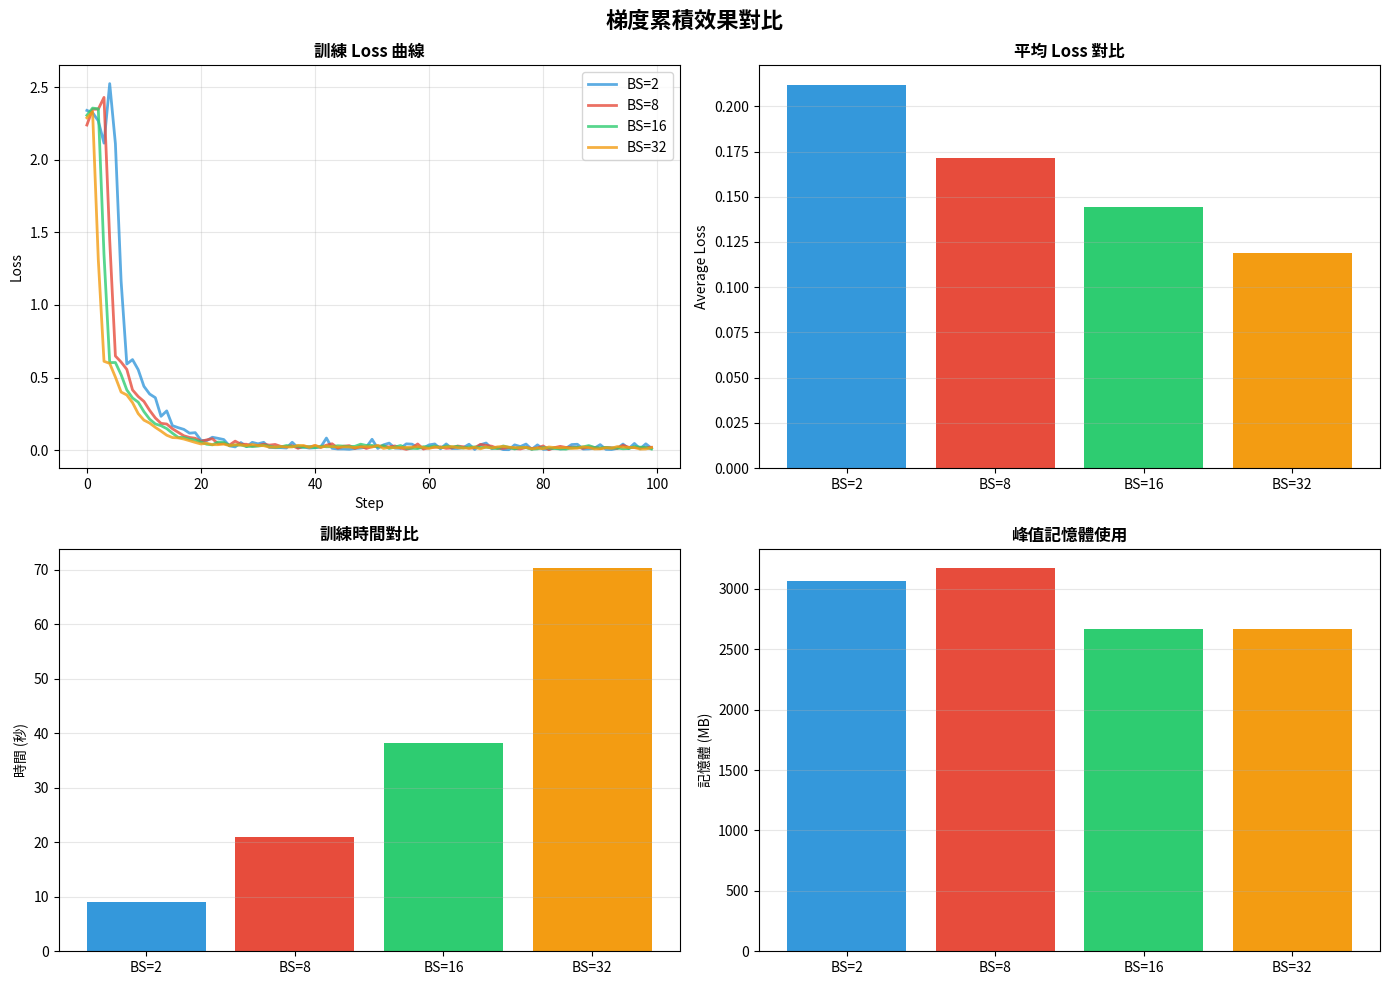

In [19]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# Ë®≠ÂÆöÂ≠óÂûãÁÇ∫ Noto Sans CJK TC
rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
rcParams['axes.unicode_minus'] = False  # ÈÅøÂÖçË≤†ËôüÈ°ØÁ§∫ÈåØË™§

# ÂâµÂª∫Â∞çÊØîÂúñË°®
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Ê¢ØÂ∫¶Á¥ØÁ©çÊïàÊûúÂ∞çÊØî", fontsize=16, fontweight="bold")

configs = ["BS=2", "BS=8", "BS=16", "BS=32"]
colors = ["#3498db", "#e74c3c", "#2ecc71", "#f39c12"]

# 1. Loss Êõ≤Á∑öÂ∞çÊØî
axes[0, 0].plot(results_baseline["losses"], label=configs[0], linewidth=2, color=colors[0], alpha=0.8)
axes[0, 0].plot(results_acc4["losses"], label=configs[1], linewidth=2, color=colors[1], alpha=0.8)
axes[0, 0].plot(results_acc8["losses"], label=configs[2], linewidth=2, color=colors[2], alpha=0.8)
axes[0, 0].plot(results_acc16["losses"], label=configs[3], linewidth=2, color=colors[3], alpha=0.8)
axes[0, 0].set_title("Ë®ìÁ∑¥ Loss Êõ≤Á∑ö", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Step")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Âπ≥Âùá Loss Â∞çÊØî
avg_losses = [r["avg_loss"] for _, r in all_results]
axes[0, 1].bar(configs, avg_losses, color=colors)
axes[0, 1].set_title("Âπ≥Âùá Loss Â∞çÊØî", fontsize=12, fontweight="bold")
axes[0, 1].set_ylabel("Average Loss")
axes[0, 1].grid(axis="y", alpha=0.3)

# 3. Ë®ìÁ∑¥ÊôÇÈñìÂ∞çÊØî
times = [r["training_time"] for _, r in all_results]
axes[1, 0].bar(configs, times, color=colors)
axes[1, 0].set_title("Ë®ìÁ∑¥ÊôÇÈñìÂ∞çÊØî", fontsize=12, fontweight="bold")
axes[1, 0].set_ylabel("ÊôÇÈñì (Áßí)")
axes[1, 0].grid(axis="y", alpha=0.3)

# 4. Ë®òÊÜ∂È´î‰ΩøÁî®Â∞çÊØî
memories = [r["peak_memory_mb"] for _, r in all_results]
axes[1, 1].bar(configs, memories, color=colors)
axes[1, 1].set_title("Â≥∞ÂÄºË®òÊÜ∂È´î‰ΩøÁî®", fontsize=12, fontweight="bold")
axes[1, 1].set_ylabel("Ë®òÊÜ∂È´î (MB)")
axes[1, 1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Loss Á©©ÂÆöÊÄßÂàÜÊûê

Ë®ìÁ∑¥Á©©ÂÆöÊÄßÂàÜÊûê (Loss Ê®ôÊ∫ñÂ∑Æ)
Baseline (BS=2)      LossÊ®ôÊ∫ñÂ∑Æ: 0.5478, ËÆäÁï∞‰øÇÊï∏: 2.5833
Accum√ó4 (BS=8)       LossÊ®ôÊ∫ñÂ∑Æ: 0.4788, ËÆäÁï∞‰øÇÊï∏: 2.7937
Accum√ó8 (BS=16)      LossÊ®ôÊ∫ñÂ∑Æ: 0.4220, ËÆäÁï∞‰øÇÊï∏: 2.9255
Accum√ó16 (BS=32)     LossÊ®ôÊ∫ñÂ∑Æ: 0.3555, ËÆäÁï∞‰øÇÊï∏: 2.9932

Ë™™Êòé: ËÆäÁï∞‰øÇÊï∏Ë∂äÂ∞è, Ë®ìÁ∑¥Ë∂äÁ©©ÂÆö
‰∏ÄËà¨ËÄåË®Ä, Êõ¥Â§ßÁöÑÊâπÊ¨°Â§ßÂ∞èÊúÉÂ∏∂‰æÜÊõ¥Á©©ÂÆöÁöÑË®ìÁ∑¥


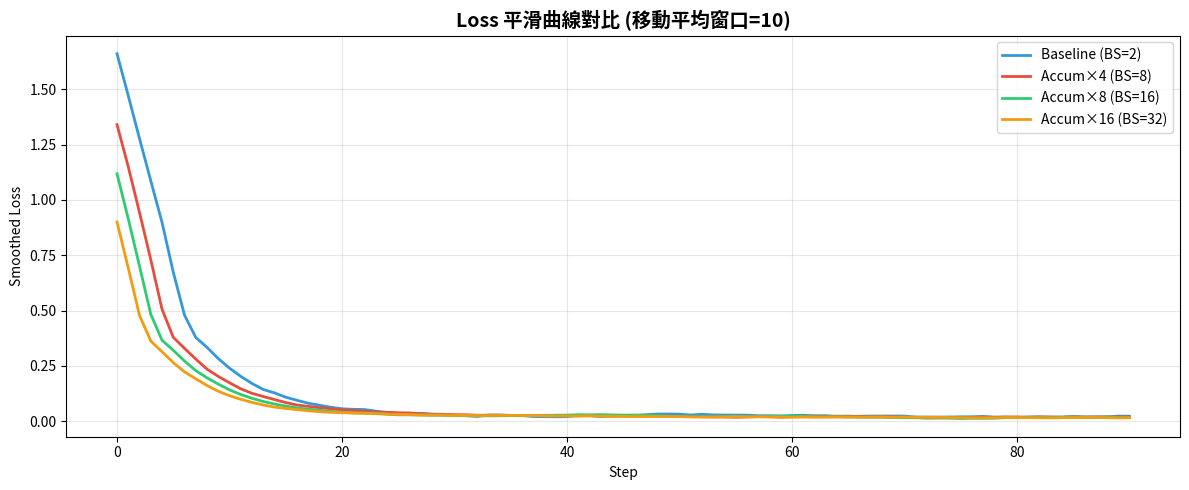

In [20]:
# Ë®àÁÆó Loss ÁöÑÊ®ôÊ∫ñÂ∑Æ (Ë°°ÈáèÁ©©ÂÆöÊÄß)
print("=" * 70)
print("Ë®ìÁ∑¥Á©©ÂÆöÊÄßÂàÜÊûê (Loss Ê®ôÊ∫ñÂ∑Æ)")
print("=" * 70)

for name, result in all_results:
    losses = result["losses"]
    loss_std = np.std(losses)
    loss_mean = np.mean(losses)
    cv = loss_std / loss_mean  # ËÆäÁï∞‰øÇÊï∏
    
    print(f"{name:<20} LossÊ®ôÊ∫ñÂ∑Æ: {loss_std:.4f}, ËÆäÁï∞‰øÇÊï∏: {cv:.4f}")

print("\nË™™Êòé: ËÆäÁï∞‰øÇÊï∏Ë∂äÂ∞è, Ë®ìÁ∑¥Ë∂äÁ©©ÂÆö")
print("‰∏ÄËà¨ËÄåË®Ä, Êõ¥Â§ßÁöÑÊâπÊ¨°Â§ßÂ∞èÊúÉÂ∏∂‰æÜÊõ¥Á©©ÂÆöÁöÑË®ìÁ∑¥")

# Áπ™Ë£Ω Loss ËÆäÂåñÁéá
plt.figure(figsize=(12, 5))

for i, (name, result) in enumerate(all_results):
    losses = result["losses"]
    # Ë®àÁÆóÁßªÂãïÂπ≥Âùá
    window_size = 10
    smoothed = np.convolve(losses, np.ones(window_size)/window_size, mode="valid")
    plt.plot(smoothed, label=name, linewidth=2, color=colors[i])

plt.title("Loss Âπ≥ÊªëÊõ≤Á∑öÂ∞çÊØî (ÁßªÂãïÂπ≥ÂùáÁ™óÂè£=10)", fontsize=14, fontweight="bold")
plt.xlabel("Step")
plt.ylabel("Smoothed Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 13. Ê¢ØÂ∫¶ÁØÑÊï∏ÂàÜÊûê

Ê¢ØÂ∫¶ÁØÑÊï∏ÂàÜÊûêÂØ¶È©ó

ÂàÜÊûê‰∏çÂêåÊ¢ØÂ∫¶Á¥ØÁ©çÈÖçÁΩÆÁöÑÊ¢ØÂ∫¶ÁØÑÊï∏...

Ê∏¨Ë©¶ accumulation_steps=1...


/tmp/ipykernel_3826037/1812340431.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):


Âπ≥ÂùáÊ¢ØÂ∫¶ÁØÑÊï∏: 11.7836
Ê¢ØÂ∫¶ÁØÑÊï∏Ê®ôÊ∫ñÂ∑Æ: 13.4469

Ê∏¨Ë©¶ accumulation_steps=4...
Âπ≥ÂùáÊ¢ØÂ∫¶ÁØÑÊï∏: 14.9016
Ê¢ØÂ∫¶ÁØÑÊï∏Ê®ôÊ∫ñÂ∑Æ: 8.7348

Ê∏¨Ë©¶ accumulation_steps=8...
Âπ≥ÂùáÊ¢ØÂ∫¶ÁØÑÊï∏: 25.9886
Ê¢ØÂ∫¶ÁØÑÊï∏Ê®ôÊ∫ñÂ∑Æ: 10.1037


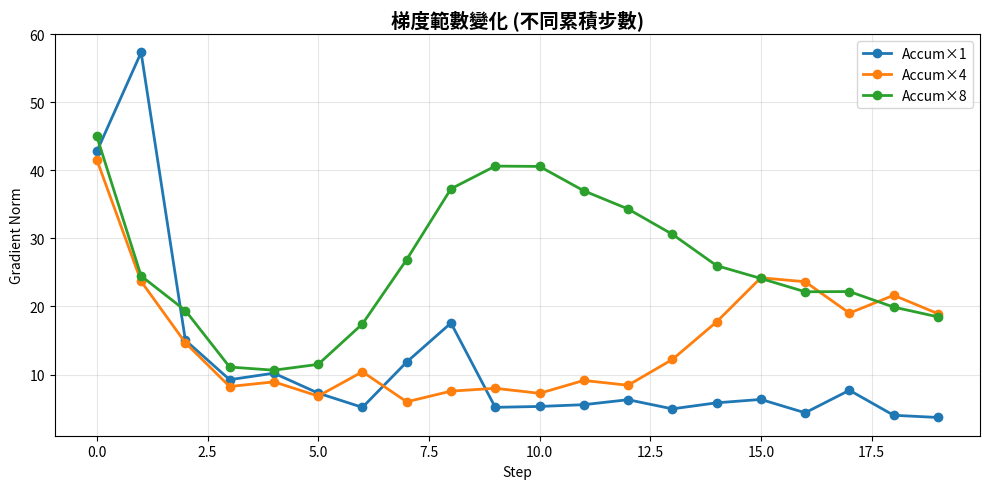


Ë™™Êòé: Êõ¥Â§ßÁöÑÁ¥ØÁ©çÊ≠•Êï∏ÈÄöÂ∏∏Â∏∂‰æÜÊõ¥Á©©ÂÆöÁöÑÊ¢ØÂ∫¶


In [21]:
print("=" * 70)
print("Ê¢ØÂ∫¶ÁØÑÊï∏ÂàÜÊûêÂØ¶È©ó")
print("=" * 70)

def analyze_gradient_norms(model, dataloader, accumulation_steps=1, num_steps=20):
    """ÂàÜÊûêÊ¢ØÂ∫¶ÁØÑÊï∏"""
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    
    grad_norms = []
    dataloader_iter = iter(dataloader)
    
    for step in range(num_steps):
        model.zero_grad()
        
        # Ê¢ØÂ∫¶Á¥ØÁ©ç
        for _ in range(accumulation_steps):
            try:
                batch = next(dataloader_iter)
            except StopIteration:
                dataloader_iter = iter(dataloader)
                batch = next(dataloader_iter)
            
            batch = {k: v.to(device) for k, v in batch.items()}
            
            with autocast(dtype=torch.float16):
                outputs = model(**batch)
                loss = outputs.loss / accumulation_steps
            
            loss.backward()
        
        # Ë®àÁÆóÊ¢ØÂ∫¶ÁØÑÊï∏
        total_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        grad_norms.append(total_norm)
        
        optimizer.step()
    
    return grad_norms

# ÂâµÂª∫Ê∏¨Ë©¶ DataLoader
test_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Ê∏¨Ë©¶‰∏çÂêåÁ¥ØÁ©çÊ≠•Êï∏
print("\nÂàÜÊûê‰∏çÂêåÊ¢ØÂ∫¶Á¥ØÁ©çÈÖçÁΩÆÁöÑÊ¢ØÂ∫¶ÁØÑÊï∏...")
grad_results = {}

for accum in [1, 4, 8]:
    print(f"\nÊ∏¨Ë©¶ accumulation_steps={accum}...")
    test_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
    
    norms = analyze_gradient_norms(test_model, test_loader, accumulation_steps=accum, num_steps=20)
    grad_results[f"Accum√ó{accum}"] = norms
    
    print(f"Âπ≥ÂùáÊ¢ØÂ∫¶ÁØÑÊï∏: {np.mean(norms):.4f}")
    print(f"Ê¢ØÂ∫¶ÁØÑÊï∏Ê®ôÊ∫ñÂ∑Æ: {np.std(norms):.4f}")
    
    del test_model
    memory_tracker.reset()

# Áπ™Ë£ΩÊ¢ØÂ∫¶ÁØÑÊï∏ËÆäÂåñ
plt.figure(figsize=(10, 5))
for name, norms in grad_results.items():
    plt.plot(norms, marker="o", label=name, linewidth=2)

plt.title("Ê¢ØÂ∫¶ÁØÑÊï∏ËÆäÂåñ (‰∏çÂêåÁ¥ØÁ©çÊ≠•Êï∏)", fontsize=14, fontweight="bold")
plt.xlabel("Step")
plt.ylabel("Gradient Norm")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nË™™Êòé: Êõ¥Â§ßÁöÑÁ¥ØÁ©çÊ≠•Êï∏ÈÄöÂ∏∏Â∏∂‰æÜÊõ¥Á©©ÂÆöÁöÑÊ¢ØÂ∫¶")

## 14. ÂØ¶È©óÁ∏ΩÁµêËàáÊúÄ‰Ω≥ÂØ¶Ë∏ê

### ÂØ¶È©óÁµêË´ñ

1. **Ë®òÊÜ∂È´îÂç†Áî®**: Ê¢ØÂ∫¶Á¥ØÁ©ç**‰∏çÊúÉÂ¢ûÂä†**Ë®òÊÜ∂È´îÂ≥∞ÂÄº ‚úÖ
   - ÊâÄÊúâÈÖçÁΩÆÁöÑË®òÊÜ∂È´î‰ΩøÁî®Âü∫Êú¨Áõ∏Âêå
   - ÂèØ‰ª•Âú®Â∞èGPU‰∏äÂØ¶ÁèæÂ§ßÊâπÊ¨°Ë®ìÁ∑¥ÊïàÊûú

2. **Ë®ìÁ∑¥ÊôÇÈñì**: Á¥ØÁ©çÊ≠•Êï∏Ë∂äÂ§ß, ÊôÇÈñìÁï•ÂæÆÂ¢ûÂä† (5-10%)
   - È°çÂ§ñÈñãÈä∑‰∏ªË¶Å‰æÜËá™Êï∏ÊìöËºâÂÖ•ÂíåÂâçÂêëÂÇ≥Êí≠
   - Áõ∏Â∞çÊñºË®òÊÜ∂È´îÁØÄÁúÅ, ‰ª£ÂÉπÂèØÊé•Âèó

3. **Ë®ìÁ∑¥Á©©ÂÆöÊÄß**: Êõ¥Â§ßÁöÑÊúâÊïàÊâπÊ¨°ÈÄöÂ∏∏Êõ¥Á©©ÂÆö
   - Loss Êõ≤Á∑öÊõ¥Âπ≥Êªë
   - Ê¢ØÂ∫¶ÁØÑÊï∏ËÆäÂåñÊõ¥Â∞è
   - Êî∂ÊñÇÊõ¥Âä†Á©©ÂÆö

4. **ÊúÄÁµÇÊïàÊûú**: Áõ∏ÂêåÊúâÊïàÊâπÊ¨°Â§ßÂ∞è, ÊïàÊûúÂü∫Êú¨Á≠âÂÉπ
   - Ê¢ØÂ∫¶Á¥ØÁ©ç vs Áõ¥Êé•Â§ßÊâπÊ¨°: Êï∏Â≠∏Á≠âÂÉπ
   - ÂØ¶ÈöõÊïàÊûúÂ∑ÆÁï∞‰∏ªË¶Å‰æÜËá™Êï∏ÂÄºÁ≤æÂ∫¶

### ÊúÄ‰Ω≥ÂØ¶Ë∏ê

#### Â¶Ç‰ΩïÈÅ∏ÊìáÁ¥ØÁ©çÊ≠•Êï∏?

```python
# Ë®àÁÆóÂÖ¨Âºè
target_batch_size = 32  # ÁõÆÊ®ôÊúâÊïàÊâπÊ¨°Â§ßÂ∞è
max_micro_batch = 4     # GPU ËÉΩÂÆπÁ¥çÁöÑÊúÄÂ§ß micro batch

accumulation_steps = target_batch_size // max_micro_batch
# 32 // 4 = 8 Ê≠•Á¥ØÁ©ç
```

#### Êé®Ëñ¶ÈÖçÁΩÆ

| GPU Ë®òÊÜ∂È´î | Micro Batch | Á¥ØÁ©çÊ≠•Êï∏ | ÊúâÊïà Batch | ÈÅ©Áî®Ê®°Âûã |
|-----------|------------|---------|-----------|----------|
| 8GB | 1-2 | 16-32 | 16-64 | GPT-2 Small |
| 16GB | 2-4 | 8-16 | 16-64 | GPT-2 Medium |
| 24GB | 4-8 | 4-8 | 16-64 | GPT-2 Large |
| 40GB+ | 8-16 | 2-4 | 16-64 | GPT-2 XL |

#### Â≠∏ÁøíÁéáË™øÊï¥

**ÈáçË¶Å**: ÊîπËÆäÊúâÊïàÊâπÊ¨°Â§ßÂ∞èÊôÇ, ÈúÄË¶ÅË™øÊï¥Â≠∏ÁøíÁéá!

```python
# Á∑öÊÄßÁ∏ÆÊîæË¶èÂâá (Linear Scaling Rule)
base_lr = 5e-5
base_batch_size = 8
new_batch_size = 32

new_lr = base_lr * (new_batch_size / base_batch_size)
# 5e-5 * (32 / 8) = 2e-4

# Êàñ‰ΩøÁî® sqrt Á∏ÆÊîæ (Êõ¥‰øùÂÆà)
new_lr = base_lr * np.sqrt(new_batch_size / base_batch_size)
```

#### ÂÆåÊï¥ÂÑ™ÂåñÈÖçÁΩÆ

```python
# Êé®Ëñ¶ÁöÑÁîüÁî¢Áí∞Â¢ÉÈÖçÁΩÆ
from torch.cuda.amp import autocast, GradScaler

# ÈÖçÁΩÆ
micro_batch_size = 2
accumulation_steps = 16
effective_batch_size = micro_batch_size * accumulation_steps  # 32

# Â≠∏ÁøíÁéáÁ∏ÆÊîæ
base_lr = 5e-5
learning_rate = base_lr * (effective_batch_size / 8)

# ÂàùÂßãÂåñ
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scaler = GradScaler()

# Ë®ìÁ∑¥Âæ™Áí∞
model.zero_grad()
for step, batch in enumerate(dataloader):
    # Á¥ØÁ©çÊ¢ØÂ∫¶
    with autocast(dtype=torch.float16):
        loss = model(**batch).loss / accumulation_steps
    
    scaler.scale(loss).backward()
    
    # Á¥ØÁ©çÂÆåÊàê, Êõ¥Êñ∞ÂèÉÊï∏
    if (step + 1) % accumulation_steps == 0:
        # Ê¢ØÂ∫¶Ë£ÅÂâ™
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Êõ¥Êñ∞
        scaler.step(optimizer)
        scaler.update()
        model.zero_grad()
```

### Â∏∏Ë¶ãÂïèÈ°å

#### Q1: Loss ÈúÄË¶ÅÈô§‰ª• accumulation_steps Âóé?
**A**: ÊòØÁöÑ! ÈÄôÊ®£ÂèØ‰ª•‰øùË≠âÁ¥ØÁ©çÁöÑÊ¢ØÂ∫¶ËàáÁõ¥Êé•Â§ßÊâπÊ¨°Ë®ìÁ∑¥‰∏ÄËá¥„ÄÇ

#### Q2: ‰ªÄÈ∫ºÊôÇÂÄôÊ∏ÖÈõ∂Ê¢ØÂ∫¶?
**A**: Âú®Á¥ØÁ©çÂÆåÊàê‰∏¶Êõ¥Êñ∞ÂèÉÊï∏**‰πãÂæå**, ËÄå‰∏çÊòØÊØèÂÄã micro-batch ‰πãÂæå„ÄÇ

#### Q3: Ê¢ØÂ∫¶Á¥ØÁ©çÊúÉÈôç‰ΩéË®ìÁ∑¥ÈÄüÂ∫¶Âóé?
**A**: ÊúÉÁï•ÂæÆÈôç‰Ωé (5-10%), ‰ΩÜÊèõ‰æÜ‰∫ÜË®òÊÜ∂È´îÁØÄÁúÅ, ÂÄºÂæó!

#### Q4: ÂèØ‰ª•ÂíåÂÖ∂‰ªñÂÑ™ÂåñÊäÄË°ìÁµÑÂêàÂóé?
**A**: ÂÆåÂÖ®ÂèØ‰ª•! Êé®Ëñ¶ÁµÑÂêà:
- ‚úÖ Ê∑∑ÂêàÁ≤æÂ∫¶Ë®ìÁ∑¥ (AMP)
- ‚úÖ Ê¢ØÂ∫¶Ê™¢Êü•Èªû (Gradient Checkpointing)
- ‚úÖ Ê¢ØÂ∫¶Á¥ØÁ©ç

ÈÄô‰∏âËÄÖÁµÑÂêàÂèØ‰ª•Âú®Â∞èGPU‰∏äË®ìÁ∑¥Â§ßÊ®°Âûã!

## 15. ‰∏ã‰∏ÄÊ≠•Â≠∏Áøí

ÂÆåÊàêÊú¨ Notebook Âæå, Âª∫Ë≠∞ÁπºÁ∫å:

1. **03-Gradient_Checkpointing.ipynb** - ÈÄ≤‰∏ÄÊ≠•Èôç‰ΩéË®òÊÜ∂È´î
2. **04-Memory_Profiling.ipynb** - Ê∑±ÂÖ•ÂàÜÊûêË®òÊÜ∂È´î‰ΩøÁî®
3. **ÁµÑÂêàÂÑ™Âåñ** - Â∞áÊâÄÊúâÊäÄË°ìÁµÑÂêàÊáâÁî®ÊñºÂØ¶ÈöõÈ†ÖÁõÆ

ÊÅ≠ÂñúÂÆåÊàêÊ¢ØÂ∫¶Á¥ØÁ©çÂØ¶È©ó! üéâ